In [1]:
import sqlite3 as sq
import numpy as np
import pickle
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib import pyplot as plt
from multiprocessing.pool import Pool
%matplotlib inline

In [2]:
def get_table(conn, table):
    out = None
    with conn:
        out = conn.execute(f"select * from {table};").fetchall();
    out_dict = {k[0]: np.array(k[1:]) for k in out}
    return (get_tau(out), out_dict)

def get_tau(table):
    return np.array(range(1, len(table[0]))) if len(table) >= 1 else None

def plot(data, key, q):
    plt.plot(data[key][0], data[key][1][q])

In [3]:
conn = sq.connect("../crowd.sqlite")

In [4]:
with conn:
    tables = conn.execute("SELECT name FROM main.sqlite_master WHERE type='table'").fetchall();

In [5]:
tables_filtered = filter(lambda t: t.find("video_multiDDM") != -1 and t.find("1024") != -1, map(lambda t: t[0], tables))

In [6]:
singleDDM_data = {k: get_table(conn, k) for k in tables_filtered}

In [7]:
crowd_data = {k: v for k, v in singleDDM_data.items() if k.find("crowd") != -1}
running_data = {k: v for k, v in singleDDM_data.items() if k.find("running") != -1}

In [8]:
def brownian_isf(tau, tauc, a, b):
    return a * ( 1 - np.exp(-tau / tauc)) + b
def ballistic_isf(tau, vq, tauc, a, b):
    return a * (1 - np.sinc(vq * tau) * np.exp(- tau / tauc)) + b

In [9]:
def fit_args(args):
    return args[0], fit(*args[1:])

def fit(f, x, y, bounds=([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])):
    try:
        params, errs = curve_fit(f, x, y, bounds=bounds)
        return params, np.sqrt(np.diag(errs))
    except RuntimeError:
        return None 
def total_fit(data, f, bounds = ([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])):
    #pool map here
    pool = Pool(10)
    return {k: pool.map(fit_args, [(q, f, v[0], d, bounds) for q, d in v[1].items()]) for k, v in data.items()}

def save_pickle(data, output: str):
    with open(output, "wb") as f:
        pickle.dump(data, f)

In [49]:
fit_brownian_crowd_data = total_fit(crowd_data, brownian_isf)
bounds = ([-np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
fit_ballistic_crowd_data = total_fit(crowd_data, ballistic_isf, bounds=bounds)

In [55]:
save_pickle(fit_brownian_crowd_data, "fit_brownian_crowd_single_ddm.pickle")
save_pickle(fit_ballistic_crowd_data, "fit_ballistic_crowd_single_ddm.pickle")

In [51]:
bounds = ([-np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
fit_ballistic_running_data = total_fit(running_data, ballistic_isf, bounds)
fit_brownian_running_data = total_fit(running_data, brownian_isf)

In [56]:
save_pickle(fit_ballistic_running_data, "fit_ballistic_running_single_ddm.pickle")
save_pickle(fit_brownian_running_data, "fit_brownian_running_single_ddm.pickle")

In [57]:
def plot_fit(data, fits, key, q, f = brownian_isf):
    temp = list(filter(lambda x: x[0] == q, fits[key]))[0]
    plot(data, key,  q)
    tau = np.linspace(0, 80)
    if temp[1] is not None:
        fit_params = temp[1][0]
        plt.plot(tau, f(tau, *fit_params))

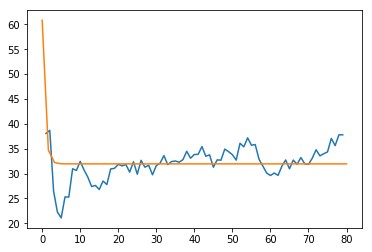

In [129]:
#ballistic fitting is not correct
plot_fit(running_data, fit_brownian_running_data, "video_multiDDM_running6_1024", 199.5, brownian_isf)

In [80]:
def extract_param(data, param = 0):
    return {k: 
    ([e[0] for e in v if e[1] is not None and abs(e[1][0][param] / e[1][1][param]) > 1],
     [e[1][0][param] for e in v if e[1] is not None and abs(e[1][0][param] / e[1][1][param]) > 1]) for k, v in data.items()}

In [106]:
tauc_brownian_crowd_data = extract_param(fit_brownian_crowd_data, 0)
tauc_brownian_running_data = extract_param(fit_brownian_running_data, 0)
tauc_ballistic_crowd_data = extract_param(fit_ballistic_crowd_data, 1)
tauc_ballistic_running_data = extract_param(fit_ballistic_running_data, 1)
vq_ballistic_crowd_data = extract_param(fit_ballistic_crowd_data, 0)
vq_ballistic_running_data = extract_param(fit_ballistic_running_data, 0)

/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [109]:
v_ballistic_crowd_data = {k: (v[0], np.divide(v[1], v[0])) for k, v in vq_ballistic_crowd_data.items()}
v_ballistic_running_data = {k: (v[0], np.divide(v[1], v[0])) for k, v in vq_ballistic_running_data.items()}

In [113]:
import os
def save_plots_tauc(data, isf: str):
    if not os.path.exists(f"{isf}_single_scale"):
        os.mkdir(f"{isf}_single_scale")
    for k, v in data.items():
        plt.plot(np.log(v[0]), np.log(v[1]))
        plt.xlabel("log(q / (1 / pixel))")
        plt.ylabel(r"log($\tau_c$ / (1 / fps))")
        plt.title(f"{k}")
        plt.savefig(f"{isf}_single_scale/{k}_tauc.png", dpi=300)
        plt.close()
        
def save_plots_v(data, isf: str):
    if not os.path.exists(f"{isf}_v_single_scale"):
        os.mkdir(f"{isf}_v_single_scale")
    for k, v in data.items():
        plt.plot(v[0], v[1])
        plt.xlabel("q / (1 / pixel)")
        plt.ylabel(r"v / (pixel / (1 / fps))")
        plt.title(f"{k}")
        plt.savefig(f"{isf}_v_single_scale/{k}_tauc.png", dpi=300)
        plt.close()

In [114]:
save_plots_tauc(tauc_brownian_crowd_data, "Brownian")
save_plots_tauc(tauc_brownian_running_data, "Brownian")
save_plots_tauc(tauc_ballistic_crowd_data, "Ballistic")
save_plots_tauc(tauc_ballistic_running_data, "Ballistic")

In [115]:
save_plots_v(v_ballistic_crowd_data, "Ballistic")
save_plots_v(v_ballistic_running_data, "Ballistic")